# Анализ данных ритейла. Нахождение точек роста выручки.

Дисклеймер: особенность работы в демонстрации только кода, без расскрытия данных, в виду конфедециального соглашения с компанией.


Работа направлена на создание гипотезы и подготовку данных к проведению A/B теста по ее проверке. Гипотеза появилась в ходе исследования, но здесь представлена вначале для лучшейго понимания процесса.

Гипотеза:                             
Если распределить магазины на сегменты по внешним данным и в каждом сегменте выбрать магазин с растущей выручкой за последние два месяца (топовый), а в магазинах с падающей выручкой (нетоповых), похожих на 97% по ассортименту товаров на магазин с растущей выручкой, и закупать количество каждого товара в нетоповых столько же, сколько в топовых, то это даст рост выручки сети магазинов.

Работа разделена на этапы:\
1). Разделение пользователей на сегманты;\
2). Нахождение магазинов с падающей выручкой относительно предыдущего месяца;\
3). Выбор магазинов в каждом сегменте по ассортименту;\
4). Подготовка к A/B тесту.

# 1). Разделение пользователей на сегменты.

Ниже представлено разделение пользователей на сегменты по уровню спроса. При этом уровень спроса будет определяться четырьмя параметрами: расстояние до метро, расстояние до ближайшей автобусной остановки, средняя дневная выручка, площадь магазина. Каждому магазину будет присвоен рейтинг: от 4 до 12. От 12 до 10 - это магазины сегмента "the best location", от 9 до 7 - это магазины из сегмента "good location", от 6 до 4 - это магазины из сегмента "bad location".

In [2]:
import pandas as pd
import datetime
#считывание данных
shops_infa=pd.read_csv('Outside/zao_info_full.csv', sep=',')
shops_infa.head(40)

,Unnamed: 0,id_tt,adress,Hours,latitude,longitude,square,city_tt,district,shtat,...,vegetables_count,meat_count,city_center_distance,cafe,coffee,avg_daily_bills_qty,avg_daily_tt_revenue,nearest_bus_stop_distance,nearest_food_distance,radius_200m_food_count
0,0,10778,"Москва район Ново-Переделкино, ул. Шолохова, д...",с 9-00 до 22-00,55.641888,37.345435,127.2,Москва,Ново-Переделкино,5,...,2,2,21.316432,0.0,1.0,791.000000,370894.633489,0.030299,0.446545,0
1,1,10780,"Москва Осенний бульвар, д. 12, корп. 6",с 7-00 до 23-30,55.758341,37.413949,111.0,Москва,Крылатское,9,...,0,0,12.991787,0.0,1.0,1270.619565,672321.763116,0.281330,0.302339,0
2,2,10786,"Москва проспект Вернадского, д. 39",с 8-00 до 22-00,55.675544,37.505894,210.0,Москва,Проспект Вернадского,5,...,4,1,11.299197,0.0,1.0,1281.239130,600530.570889,0.058936,0.034460,6
3,3,10904,"Москва ул. 26 Бакинских Комиссаров, д. 8, корп. 2",с 9-00 до 22-00,55.659170,37.491359,114.5,Москва,Тропарево-Никулино,3,...,5,2,13.294490,0.0,1.0,546.336957,242886.435490,0.134242,0.220495,0
4,4,11020,"Москва ул. Покрышкина, д. 7, корп. 1 + ""ВкусВи...",с 8-00 до 22-00,55.664604,37.468192,200.0,Москва,Тропарево-Никулино,6,...,0,0,13.790432,1.0,0.0,796.684783,423825.505063,0.033607,0.040488,3
5,5,11103,"Москва Можайское шоссе, д. 28",с 8-00 до 22-00,55.720249,37.421364,155.4,Москва,Можайский,5,...,4,5,13.061975,0.0,1.0,766.097826,364035.218914,0.087971,0.107920,2
6,6,11159,"Москва Украинский бульвар, д. 6",с 9-00 до 22-00,55.747647,37.565048,182.0,Москва,Дорогомилово,2,...,2,0,3.558024,0.0,1.0,584.293478,288958.782913,0.188272,0.118026,3
7,7,11290,Москва ул. Истринская д.10 к.1,с 7-00 до 23-30,55.737010,37.435178,181.0,Москва,Кунцево,8,...,0,0,11.797723,0.0,1.0,805.706522,512853.060004,0.163923,0.409014,0
8,8,11309,"Москва ул. Новопеределкинская, д. 9а",с 9-00 до 22-00,55.640309,37.366071,120.0,Москва,Ново-Переделкино,3,...,2,2,20.385575,0.0,1.0,453.445652,222238.483316,0.059592,0.005868,2
9,9,11420,"Москва ул. Багрицкого, д. 3, к. 1",с 9-00 до 22-00,55.723967,37.437173,147.0,Москва,Можайский,4,...,2,2,11.992188,0.0,1.0,592.989130,308297.239632,0.262884,0.329715,0


In [2]:
#Удаление ненужных столбцов из датафрейма внешних данных.
shops_infa=shops_infa.drop(['adress','latitude','city_tt','district','longitude','format','shtat',\
                           'qty_kassa','qty_kassa_so','vegetables_count','meat_count'\
                           ,'cafe','coffee','nearest_food_distance','universam_count_500m','city_center_distance','radius_200m_food_count',\
                           'avg_daily_bills_qty','Hours','avg_monthly_bills_qty'],axis=1)
shops_infa

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance
0,0,10778,127.2,0.665121,370894.633489,0.030299
1,1,10780,111.0,0.414311,672321.763116,0.281330
2,2,10786,210.0,0.187455,600530.570889,0.058936
3,3,10904,114.5,0.706927,242886.435490,0.134242
4,4,11020,200.0,0.959277,423825.505063,0.033607
...,...,...,...,...,...,...
79,79,15753,182.1,0.314743,312820.540612,0.197652
80,80,15834,174.5,1.038721,159547.530023,0.375907
81,81,15970,224.0,0.512430,157006.546294,0.041375
82,82,15986,304.0,0.466486,350874.292950,0.063084


In [3]:
#Ниже представлены квантили для каждого параметра спроса: 0,33 и 0,66.
quantiles=shops_infa.quantile(q=[0.33,0.66])
quantiles

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance
0.33,27.39,11893.07,125.248,0.416853,239557.284008,0.070873
0.66,54.78,12868.58,168.120,0.830571,363243.483973,0.149626


In [4]:
#"RClass" - функция для присвоения значения 1, 2 или 3  для значений, попадающих между соответствующими квантилями. 
#Эта функция для параметров спроса, в которых чем больше, тем лучше, а значит больше "очков" для каждого сегмента. 
#Это параметры: площадь магазина и средняя дневная выручка. Чем больше "очков", тем лучше спрос магазина.
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.33]:
        return 1
    elif value <= quantiles_table[parameter_name][0.66]:
        return 2
    else:
        return 3
#"FMClass" - функция для присвоения значения 1, 2 или 3  для значений, попадающих между соответствующими квантилями. 
#Эта функция для параметров спроса, в которых чем меньше, тем лучше, а значит больше "очков" для каждого сегмента. 
#Это параметры: площадь магазина и средняя дневная выручка.    
def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.33]:
        return 3   
    elif value <= quantiles_table[parameter_name][0.66]: 
        return 2
    else:
        return 1

In [5]:
    #Присвоение "очков" каждому магазину и его параметрам и получение общего рейтинга "Score".
shops_infa['square_0'] = shops_infa['square'].apply(RClass, args=('square',quantiles))

shops_infa['nearest_metro_distance_0'] = shops_infa['nearest_metro_distance'].apply(FMClass, args=('nearest_metro_distance',quantiles))

shops_infa['avg_daily_tt_revenue_0'] = shops_infa['avg_daily_tt_revenue'].apply(RClass, args=('avg_daily_tt_revenue',quantiles))

shops_infa['nearest_bus_stop_distance_0'] = shops_infa['nearest_bus_stop_distance'].apply(FMClass, args=('nearest_bus_stop_distance',quantiles))

shops_infa['Score'] = shops_infa['square_0'] + shops_infa['nearest_metro_distance_0']+\
                        shops_infa['avg_daily_tt_revenue_0'] + shops_infa['nearest_bus_stop_distance_0']
shops_infa

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance,square_0,nearest_metro_distance_0,avg_daily_tt_revenue_0,nearest_bus_stop_distance_0,Score
0,0,10778,127.2,0.665121,370894.633489,0.030299,2,2,3,3,10
1,1,10780,111.0,0.414311,672321.763116,0.281330,1,3,3,1,8
2,2,10786,210.0,0.187455,600530.570889,0.058936,3,3,3,3,12
3,3,10904,114.5,0.706927,242886.435490,0.134242,1,2,2,2,7
4,4,11020,200.0,0.959277,423825.505063,0.033607,3,1,3,3,10
...,...,...,...,...,...,...,...,...,...,...,...
79,79,15753,182.1,0.314743,312820.540612,0.197652,3,3,2,1,9
80,80,15834,174.5,1.038721,159547.530023,0.375907,3,1,1,1,6
81,81,15970,224.0,0.512430,157006.546294,0.041375,3,2,1,3,9
82,82,15986,304.0,0.466486,350874.292950,0.063084,3,2,2,3,10


In [6]:
#определение уникальных значений рейтинга, которые получились. 
#Видно, что значения "3" нет, поэтому можно разбить на три равные группы.
shops_infa.Score.unique()

array([10,  8, 12,  7,  9,  6, 11,  5,  4])

In [7]:
#Отбор магазинов с плохим рейтингом в сегмент "bad_location"
bad_location=shops_infa.query('Score==4 or Score==5 or Score==6')
bad_location

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance,square_0,nearest_metro_distance_0,avg_daily_tt_revenue_0,nearest_bus_stop_distance_0,Score
15,15,11658,103.8,0.221505,162544.212656,0.168900,1,3,1,1,6
19,19,11723,118.0,0.239842,182973.602626,0.168514,1,3,1,1,6
26,26,11855,131.6,1.027169,291545.074060,0.225625,2,1,2,1,6
32,32,11980,153.7,1.213088,229621.134370,0.184809,2,1,1,1,5
33,33,12004,117.3,0.129294,230965.082023,0.567862,1,3,1,1,6
35,35,12072,107.8,2.506965,186606.361701,0.115168,1,1,1,2,5
39,39,12261,96.0,0.796983,245000.904685,0.181914,1,2,2,1,6
40,40,12285,112.2,0.694133,228193.391748,0.281585,1,2,1,1,5
43,43,12332,132.6,1.087687,175455.367333,0.087678,2,1,1,2,6
44,44,12335,81.2,0.673969,167290.003952,0.098762,1,2,1,2,6


In [8]:
#Получение номеров магазинов, которые относятся к сегменту по спросу "bad location"
bad_location.id_tt.unique()

array([11658, 11723, 11855, 11980, 12004, 12072, 12261, 12285, 12332,
       12335, 12458, 12518, 12712, 12821, 12895, 12938, 13012, 13168,
       13429, 13623, 13767, 13926, 15834])

In [9]:
#Подсчет числа магазинов из сегмента "bad location"
bad_location.id_tt.nunique()

23

In [10]:
#Отбор магазинов со средним рейтингом в сегмент "good_location"
good_location=shops_infa.query('Score==7 or Score==8 or Score==9')
good_location

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance,square_0,nearest_metro_distance_0,avg_daily_tt_revenue_0,nearest_bus_stop_distance_0,Score
1,1,10780,111.0,0.414311,672321.763116,0.281330,1,3,3,1,8
3,3,10904,114.5,0.706927,242886.435490,0.134242,1,2,2,2,7
5,5,11103,155.4,1.828447,364035.218914,0.087971,2,1,3,2,8
6,6,11159,182.0,0.327388,288958.782913,0.188272,3,3,2,1,9
7,7,11290,181.0,0.959627,512853.060004,0.163923,3,1,3,1,8
8,8,11309,120.0,0.682796,222238.483316,0.059592,1,2,1,3,7
9,9,11420,147.0,0.784645,308297.239632,0.262884,2,2,2,1,7
10,10,11458,152.0,0.505879,329201.272520,0.257133,2,2,2,1,7
11,11,11610,140.5,0.785173,282125.083645,0.076804,2,2,2,2,8
16,16,11662,150.0,0.608107,247009.268840,0.025988,2,2,2,3,9


In [11]:
#Получение номеров магазинов, которые относятся к сегменту по спросу "good location"
good_location.id_tt.unique()

array([10780, 10904, 11103, 11159, 11290, 11309, 11420, 11458, 11610,
       11662, 11673, 11697, 11750, 11766, 11777, 11841, 11888, 11901,
       11937, 11958, 12025, 12299, 12326, 12338, 12481, 12596, 12834,
       12871, 12879, 12892, 13262, 13316, 13342, 13569, 14228, 14899,
       15175, 15239, 15753, 15970, 16130])

In [12]:
#Подсчет числа магазинов из сегмента "good location"
good_location.id_tt.nunique()

41

In [13]:
#Отбор магазинов с лучшим рейтингом в сегмент "the_best_location"
the_best_location=shops_infa.query('Score==10 or Score==11 or Score==12')
the_best_location

,Unnamed: 0,id_tt,square,nearest_metro_distance,avg_daily_tt_revenue,nearest_bus_stop_distance,square_0,nearest_metro_distance_0,avg_daily_tt_revenue_0,nearest_bus_stop_distance_0,Score
0,0,10778,127.2,0.665121,370894.633489,0.030299,2,2,3,3,10
2,2,10786,210.0,0.187455,600530.570889,0.058936,3,3,3,3,12
4,4,11020,200.0,0.959277,423825.505063,0.033607,3,1,3,3,10
12,12,11634,127.3,0.520945,485504.560069,0.054347,2,2,3,3,10
13,13,11650,199.8,2.382831,364998.048377,0.035178,3,1,3,3,10
14,14,11657,197.7,0.059714,722135.445288,0.060054,3,3,3,3,12
23,23,11783,176.0,1.244184,486681.174299,0.056965,3,1,3,3,10
25,25,11847,218.4,0.846701,370690.275995,0.059903,3,1,3,3,10
30,30,11955,279.2,0.752800,849692.309945,0.067154,3,2,3,3,11
36,36,12084,138.5,0.121749,416095.429684,0.062206,2,3,3,3,11


In [14]:
#Получение номеров магазинов, которые относятся к сегменту по спросу "the best location"
the_best_location.id_tt.unique()

array([10778, 10786, 11020, 11634, 11650, 11657, 11783, 11847, 11955,
       12084, 12132, 12192, 12392, 12860, 13018, 14025, 14030, 14396,
       14855, 15986])

In [15]:
#Подсчет числа магазинов из сегмента "the best location"
the_best_location.id_tt.nunique()

20

# 2). Нахождение магазинов с падающей выручкой относительно предыдущего месяца.

Получение данных о покупках за март, апрель и май.\
CheckId - идентификатор покупки \
id_tt_cl - код магазина\
id_tov_cl - код товара\
Price_retail - цена продукта, потупающего со склада\ 
Quantity - количество покупаемого товара\
BasePrice - цена продаваемого товара с учетом скидок\ 
BaseSum - стоимость товара с учетом скидок и \
date_ch - дата покупки\
time_ch - время покупки\
order_type - тип онлайн или оффлайн покупка

In [16]:
#считывание данных покупок за март, меняем тип данных колонки даты
march=pd.read_csv('1_march.csv', sep=';')
march.date_ch=pd.to_datetime(march.date_ch)
march.head(5)

,CheckUID,id_tt_cl,id_tov_cl,Price_retail,Quantity,BasePrice,BaseSum,date_ch,time_ch,order_type
0,869912E5-5A99-EC11-9064-005056A7A8DF,10780,14993,54.166667,1.0,54.166667,54.166667,2022-03-01,15:25:49,online
1,4F16F37D-3F99-EC11-9064-005056A7A8DF,10780,15038,121.666667,1.0,121.666667,121.666667,2022-03-01,12:06:08,offline
2,B4AA336D-4D99-EC11-9064-005056A7A8DF,10780,15038,121.666667,1.0,121.666667,121.666667,2022-03-01,13:31:36,offline
3,F99EF10C-2199-EC11-9064-005056A7A8DF,10780,15038,121.666667,1.0,121.666667,121.666667,2022-03-01,08:32:33,offline
4,FBA17678-4399-EC11-9064-005056A7A8DF,10780,15038,121.666667,1.0,121.666667,121.666667,2022-03-01,12:27:33,offline


In [17]:
#считывание данных покупок за апрель, меняем тип данных колонки даты
april=pd.read_csv('1_april.csv', sep=';')
april.date_ch=pd.to_datetime(april.date_ch)
april.head(5)

,CheckUID,id_tt_cl,id_tov_cl,Price_retail,Quantity,BasePrice,BaseSum,date_ch,time_ch,order_type
0,4BD25902-E1B1-EC11-9064-005056A7A8DF,10780,18168,36.363636,1.0,36.363636,36.363636,2022-04-01,20:13:47,offline
1,A81895A5-D5B1-EC11-9064-005056A7A8DF,10780,18168,36.363636,1.0,36.363636,36.363636,2022-04-01,18:56:55,offline
2,025A02A0-9BB1-EC11-9064-005056A7A8DF,10780,18172,95.833333,1.0,95.833333,95.833333,2022-04-01,12:05:27,offline
3,9A42B854-A2B1-EC11-9064-005056A7A8DF,10780,18175,212.500000,1.0,212.500000,212.500000,2022-04-01,12:48:00,offline
4,4400036B-ACB1-EC11-9064-005056A7A8DF,10780,18183,46.363636,1.0,46.363636,46.363636,2022-04-01,13:58:45,offline


In [18]:
#считывание данных покупок за май, меняем тип данных колонки даты
may=pd.read_csv('1_may.csv', sep=';')
may.date_ch=pd.to_datetime(may.date_ch)
may.head(5)

,CheckUID,id_tt_cl,id_tov_cl,Price_retail,Quantity,BasePrice,BaseSum,date_ch,time_ch,order_type
0,0582BCE7-48C9-EC11-9064-005056A7A8DF,10778,52,131.818182,1.0,118.181818,118.181818,2022-05-01,15:17:07,offline
1,632772C0-5CC9-EC11-9064-005056A7A8DF,10778,52,131.818182,1.0,131.818182,131.818182,2022-05-01,17:30:42,offline
2,A9818E83-5EC9-EC11-9064-005056A7A8DF,10778,52,131.818182,1.0,131.818182,131.818182,2022-05-01,17:44:52,offline
3,FDE74DEC-56C9-EC11-9064-005056A7A8DF,10778,52,131.818182,1.0,131.818182,131.818182,2022-05-01,16:51:22,offline
4,0245D76A-35C9-EC11-9064-005056A7A8DF,10778,61,74.545455,3.0,59.090909,177.272727,2022-05-01,12:50:33,offline


In [19]:
#нахождение выручки магазина за каждый день в апреле
april_profit_12192=april.query('order_type=="offline" and id_tt_cl==12192')\
                        .groupby(['date_ch'],as_index=False)\
                        .agg({'BaseSum':'sum'})
april_profit_12192.head(5)

,date_ch,BaseSum
0,2022-04-01,447187.593938
1,2022-04-02,365159.046211
2,2022-04-03,349562.711363
3,2022-04-04,459239.432574
4,2022-04-05,464796.078786


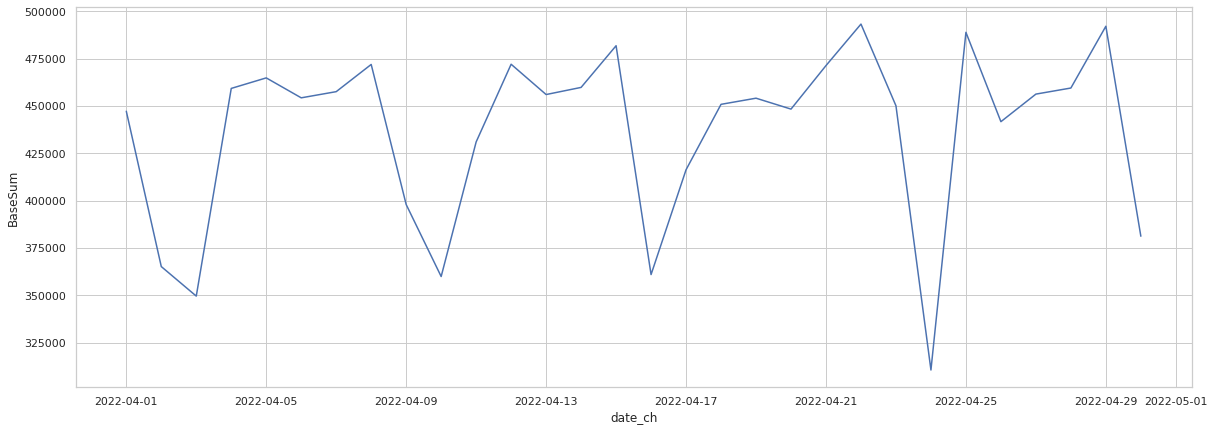

In [20]:
#загрузка библиотеки для построения графика
import seaborn as sns
#установка параметров графика
sns.set(rc={'figure.figsize':(20,7)}, style="whitegrid")
# построение графика получаемой выручки по дням для одного из магазинов в апреле
sns.lineplot(x='date_ch',y='BaseSum',data=april_profit_12192)

Как в одном магазине, так и во всех видим падение выручки в выходные дни. Работники это связывают с тем, что люди уезжают на выходные за город, на дачу и т.д.

In [21]:
#нахождение выручки за каждый из месяцев и каждый из дней
march_profit=march.query('order_type=="offline"')\
                  .groupby(['id_tt_cl','date_ch'],as_index=False)\
                  .agg({'BaseSum':'sum'})
march_profit.head(5)

,id_tt_cl,date_ch,BaseSum
0,10778,2022-03-01,349991.641666
1,10778,2022-03-02,347866.578787
2,10778,2022-03-03,363336.408332
3,10778,2022-03-04,403867.474241
4,10778,2022-03-05,428544.042423


In [22]:
april_profit=april.query('order_type=="offline"')\
                  .groupby(['id_tt_cl','date_ch'],as_index=False)\
                  .agg({'BaseSum':'sum'})
april_profit.head(5)

,id_tt_cl,date_ch,BaseSum
0,10778,2022-04-01,405784.595453
1,10778,2022-04-02,380439.307575
2,10778,2022-04-03,385012.743181
3,10778,2022-04-04,390454.598484
4,10778,2022-04-05,373881.947726


In [23]:
may_profit=may.query('order_type=="offline"')\
              .groupby(['id_tt_cl','date_ch'],as_index=False)\
              .agg({'BaseSum':'sum'})
may_profit.head(5)

,id_tt_cl,date_ch,BaseSum
0,10778,2022-05-01,299451.353029
1,10778,2022-05-02,278772.678029
2,10778,2022-05-03,310824.339393
3,10778,2022-05-04,377138.701514
4,10778,2022-05-05,374932.595453


In [24]:
#объединение выручки по дням в один датафрейм, состоящий из 3х месяцев
april_march_may_profit=pd.concat([march_profit,april_profit,may_profit],axis=0)
april_march_may_profit.head(5)

,id_tt_cl,date_ch,BaseSum
0,10778,2022-03-01,349991.641666
1,10778,2022-03-02,347866.578787
2,10778,2022-03-03,363336.408332
3,10778,2022-03-04,403867.474241
4,10778,2022-03-05,428544.042423


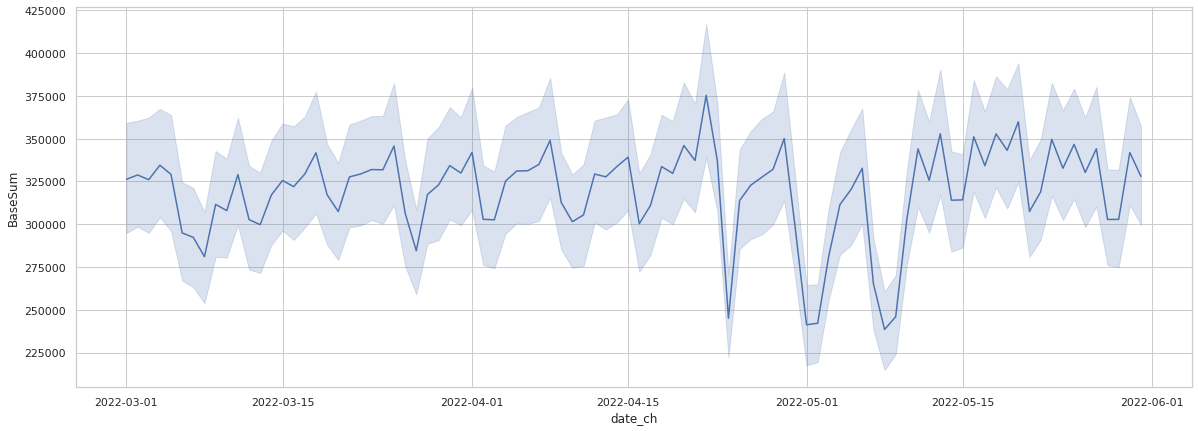

In [25]:
# построение графика получаемой выручки по дням для одного из магазинов за три месяца
sns.lineplot(x='date_ch',y='BaseSum',data=april_march_may_profit)

По графику заметны провалы выручки 24 апреля, 1 мая, 8 мая. Все это праздники, совпадающие с выходными днями. 24 апреля - Пасха, 1 мая - День труда, 9 мая - День Победы

In [26]:
#Нахождение выручки за март
total_march_profit=march_profit.groupby('id_tt_cl',as_index=False)\
                               .agg({'BaseSum':'sum'})
total_march_profit.head(5)

,id_tt_cl,BaseSum
0,10778,1.170720e+07
1,10780,1.998865e+07
2,10786,1.854676e+07
3,10904,7.656805e+06
4,11020,1.329204e+07


In [27]:
#Нахождение выручки за апрель
total_april_profit=april_profit.groupby('id_tt_cl',as_index=False)\
                               .agg({'BaseSum':'sum'})
total_april_profit.head(5)

,id_tt_cl,BaseSum
0,10778,1.149539e+07
1,10780,2.086728e+07
2,10786,1.815893e+07
3,10904,7.269242e+06
4,11020,1.300649e+07


In [28]:
#Нахождение выручки за май
total_may_profit=may_profit.groupby('id_tt_cl',as_index=False)\
                           .agg({'BaseSum':'sum'})
total_may_profit.head(5)

,id_tt_cl,BaseSum
0,10778,1.091971e+07
1,10780,2.099768e+07
2,10786,1.854313e+07
3,10904,7.419505e+06
4,11020,1.269341e+07


In [29]:
#датафрейм с выручки за март и апрель
total_march_april=total_march_profit.merge(total_april_profit, on='id_tt_cl')
total_march_april.rename(columns = {'BaseSum_x' : 'March', 'BaseSum_y' : 'April'}, inplace = True)
total_march_april.head(5)


,id_tt_cl,March,April
0,10778,1.170720e+07,1.149539e+07
1,10780,1.998865e+07,2.086728e+07
2,10786,1.854676e+07,1.815893e+07
3,10904,7.656805e+06,7.269242e+06
4,11020,1.329204e+07,1.300649e+07


In [30]:
#датафрейм с выручки за март, апрель, май
total_march_april_may=total_march_april.merge(total_may_profit, on='id_tt_cl')
total_march_april_may.rename(columns = {'BaseSum' : 'May'}, inplace = True)
total_march_april_may.head(5)

,id_tt_cl,March,April,May
0,10778,1.170720e+07,1.149539e+07,1.091971e+07
1,10780,1.998865e+07,2.086728e+07,2.099768e+07
2,10786,1.854676e+07,1.815893e+07,1.854313e+07
3,10904,7.656805e+06,7.269242e+06,7.419505e+06
4,11020,1.329204e+07,1.300649e+07,1.269341e+07


In [31]:
#формирование датафрейма с изменением процента выручки относительно предыдущего месяца
difference = pd.DataFrame(columns=['Shop','April-March', 'May-April'])
difference['April-March']=total_march_april_may.April/\
                          total_march_april_may.March*100-100
difference['May-April']=total_march_april_may.May/\
                          total_march_april_may.April*100-100
difference['Shop']=total_march_april_may.id_tt_cl
difference.head(5)


,Shop,April-March,May-April
0,10778,-1.809227,-5.007891
1,10780,4.395635,0.624911
2,10786,-2.091076,2.115767
3,10904,-5.061673,2.067098
4,11020,-2.148242,-2.407129


Находим недельные выручки по магазинам

In [32]:
#формирование столбца с номерами недель для датасета с выручкой за день для каждого магазина
Week=april_march_may_profit.date_ch.dt.strftime('%W')
Week.head(5)

0    09
1    09
2    09
3    09
4    09
Name: date_ch, dtype: object

In [33]:
#создание датафрейма с выручкой за каждый день каждого магазина с обозначением номера недели вместо даты
Weak_MAM=pd.DataFrame({'id_tt_cl':april_march_may_profit.id_tt_cl\
                       ,'Week':Week\
                       ,'BaseSum':april_march_may_profit.BaseSum})
Weak_MAM.head(5)

,id_tt_cl,Week,BaseSum
0,10778,09,349991.641666
1,10778,09,347866.578787
2,10778,09,363336.408332
3,10778,09,403867.474241
4,10778,09,428544.042423


In [34]:
#убираем из датафрейма данные о последних неделях, так как там неполные недели, что даст неверные данные для выручки за неделю
Weak_MAM_without_09_22=Weak_MAM.query("Week!='22' and Week!='09'")
Weak_MAM_without_09_22.head(5)

,id_tt_cl,Week,BaseSum
6,10778,10,425290.502272
7,10778,10,394202.765150
8,10778,10,363630.414393
9,10778,10,342836.111363
10,10778,10,383575.788635


In [35]:
#формирование датасета с выручкой за каждую неделю каждого магазина
profit_for_every_weak_MAM=Weak_MAM_without_09_22.groupby(['id_tt_cl','Week']).agg({'BaseSum':'sum'})
profit_for_every_weak_MAM.head(5)

BaseSum
id_tt_cl Week              
10778    10    2.696655e+06
         11    2.659320e+06
         12    2.625745e+06
         13    2.613224e+06
         14    2.708388e+06

In [36]:
#формирование таблицы pivot для выручки с номером недели для колонок и номером магазина в строках
pivot_weeks=pd.pivot_table(profit_for_every_weak_MAM,index='id_tt_cl', columns='Week',values='BaseSum')
pivot_weeks.head(5)

Week,10,11,12,13,14,15,16,17,18,19,20,21
id_tt_cl,,,,,,,,,,,,
10778,2.696655e+06,2.659320e+06,2.625745e+06,2.613224e+06,2.708388e+06,2.579447e+06,2.791584e+06,2.544187e+06,2.419045e+06,2.524815e+06,2.503645e+06,2.533738e+06
10780,4.122956e+06,4.684515e+06,4.731400e+06,4.905158e+06,4.851046e+06,4.674495e+06,4.997456e+06,4.888664e+06,4.397286e+06,4.692531e+06,5.178004e+06,4.811458e+06
10786,4.011754e+06,4.222037e+06,4.238394e+06,4.179198e+06,4.291320e+06,4.219076e+06,4.320433e+06,4.115724e+06,3.721471e+06,4.037657e+06,4.529775e+06,4.506979e+06
10904,1.673227e+06,1.733926e+06,1.730935e+06,1.702674e+06,1.722055e+06,1.658968e+06,1.705557e+06,1.649320e+06,1.578604e+06,1.655056e+06,1.741892e+06,1.726179e+06
11020,2.742904e+06,3.192751e+06,3.014538e+06,2.992843e+06,3.073788e+06,3.002024e+06,3.091287e+06,2.885619e+06,2.584289e+06,2.865354e+06,3.096254e+06,3.003290e+06


In [37]:
# убираем данные по магазинам 16250 и 11217, так как в них отсттствует около половины данных
pivot_weeks_witjout_NaN=pivot_weeks.query("id_tt_cl!='16250' and id_tt_cl!='11217'")
pivot_weeks_witjout_NaN.head(5)

Week,10,11,12,13,14,15,16,17,18,19,20,21
id_tt_cl,,,,,,,,,,,,
10778,2.696655e+06,2.659320e+06,2.625745e+06,2.613224e+06,2.708388e+06,2.579447e+06,2.791584e+06,2.544187e+06,2.419045e+06,2.524815e+06,2.503645e+06,2.533738e+06
10780,4.122956e+06,4.684515e+06,4.731400e+06,4.905158e+06,4.851046e+06,4.674495e+06,4.997456e+06,4.888664e+06,4.397286e+06,4.692531e+06,5.178004e+06,4.811458e+06
10786,4.011754e+06,4.222037e+06,4.238394e+06,4.179198e+06,4.291320e+06,4.219076e+06,4.320433e+06,4.115724e+06,3.721471e+06,4.037657e+06,4.529775e+06,4.506979e+06
10904,1.673227e+06,1.733926e+06,1.730935e+06,1.702674e+06,1.722055e+06,1.658968e+06,1.705557e+06,1.649320e+06,1.578604e+06,1.655056e+06,1.741892e+06,1.726179e+06
11020,2.742904e+06,3.192751e+06,3.014538e+06,2.992843e+06,3.073788e+06,3.002024e+06,3.091287e+06,2.885619e+06,2.584289e+06,2.865354e+06,3.096254e+06,3.003290e+06


In [38]:
#получение разницы в приыбыли относительно предыдущей недели для каждого магазина
Every_week_diff=pivot_weeks_witjout_NaN.pct_change(axis='columns')*100
Every_week_diff=Every_week_diff.round(2)
Every_week_diff.head(5)

Week,10,11,12,13,14,15,16,17,18,19,20,21
id_tt_cl,,,,,,,,,,,,
10778,NaN,-1.38,-1.26,-0.48,3.64,-4.76,8.22,-8.86,-4.92,4.37,-0.84,1.20
10780,NaN,13.62,1.00,3.67,-1.10,-3.64,6.91,-2.18,-10.05,6.71,10.35,-7.08
10786,NaN,5.24,0.39,-1.40,2.68,-1.68,2.40,-4.74,-9.58,8.50,12.19,-0.50
10904,NaN,3.63,-0.17,-1.63,1.14,-3.66,2.81,-3.30,-4.29,4.84,5.25,-0.90
11020,NaN,16.40,-5.58,-0.72,2.70,-2.33,2.97,-6.65,-10.44,10.88,8.06,-3.00


присваиваем нетоповым магазам (99% от всех) прибыль топовых


In [39]:
#суммарная выручка для двух последних недель для всех 82х магазинов
two_weeks_old_profit_of_all_location=pivot_weeks_witjout_NaN[['20','21']].sum()
TOTAL_two_weeks_old_profit_of_all_location=two_weeks_old_profit_of_all_location.sum()
TOTAL_two_weeks_old_profit_of_all_location

392818271.0995727

In [40]:
#Находим топовые магазины в каждом сегменте 
#потому что даже в сегменте магазинов с отличной локацией может быть отрийцательная прибыль
#best_location
best_location_difference=difference.query('Shop==10778 or Shop==10786 or Shop==11020 or Shop==11634 or Shop==11650 or Shop==\
        11657 or Shop==11783 or Shop== 11847 or Shop==11955\
        or Shop==12084 or Shop== 12132 or Shop== 12192 or Shop== 12392 or Shop== 12860 or Shop==\
        13018 or Shop==14025 or Shop==14030 or Shop==14396\
        or Shop==14855 or Shop== 15986')
best_location_difference
#good_location
good_location_difference=difference.query('Shop==10780 or Shop==10904 or Shop==11103 \
        or Shop==11159 or Shop==11290 or   Shop==11309    or Shop==11420 or Shop== 11458 or Shop==11610  or  \
         Shop==11662 or Shop== 11673 or Shop== 11697 or Shop== 11750 or \
         Shop== 11766 or Shop==11777 or Shop==11841 or Shop==11888 or Shop==11901 or Shop==11937 or Shop== 11958 or\
         Shop==12025 or Shop== 12299 or Shop== 12326 or \
         Shop== 12338 or Shop==12481 or Shop== 12596 or Shop== 12834 or Shop== 12871 or\
         Shop==12879 or Shop== 12892 or Shop== 13262 or Shop== 13316 or  \
         Shop==13342 or Shop== 13569 or Shop== 14228 or Shop== 14899 or  \
          Shop==15175 or Shop== 15239 or Shop== 15753 or Shop== 15970 or Shop== 16130')
good_location_difference
#bad_location
bad_location_difference=difference.query('Shop==11658 or Shop==11723 or Shop==11855 \
        or Shop==11980 or Shop==12004 or   Shop==12072    or Shop==12261 or Shop== 12285 or Shop==12332  or  \
         Shop==12335 or Shop== 12458 or Shop== 12518 or Shop== 12712 or \
         Shop== 12821 or Shop==12895 or Shop==12938 or Shop==13012 or Shop==13168 or Shop==13429 or Shop== 13623 or\
         Shop==13767 or Shop== 13926 or Shop== 15834')
bad_location_difference

,Shop,April-March,May-April
15,11658,-4.611001,-1.728709
19,11723,-3.884426,0.424507
26,11855,1.509145,5.639572
32,11980,-5.006866,1.804965
33,12004,-0.531108,-0.661065
35,12072,-4.773571,-1.601625
39,12261,0.352744,-1.429159
40,12285,-4.898116,-1.661965
43,12332,-3.677275,1.224260
44,12335,-4.192948,-0.934583


In [41]:
pivot_weeks_witjout_NaN


Week,10,11,12,13,14,15,16,17,18,19,20,21
id_tt_cl,,,,,,,,,,,,
10778,2.696655e+06,2.659320e+06,2.625745e+06,2.613224e+06,2.708388e+06,2.579447e+06,2.791584e+06,2.544187e+06,2.419045e+06,2.524815e+06,2.503645e+06,2.533738e+06
10780,4.122956e+06,4.684515e+06,4.731400e+06,4.905158e+06,4.851046e+06,4.674495e+06,4.997456e+06,4.888664e+06,4.397286e+06,4.692531e+06,5.178004e+06,4.811458e+06
10786,4.011754e+06,4.222037e+06,4.238394e+06,4.179198e+06,4.291320e+06,4.219076e+06,4.320433e+06,4.115724e+06,3.721471e+06,4.037657e+06,4.529775e+06,4.506979e+06
10904,1.673227e+06,1.733926e+06,1.730935e+06,1.702674e+06,1.722055e+06,1.658968e+06,1.705557e+06,1.649320e+06,1.578604e+06,1.655056e+06,1.741892e+06,1.726179e+06
11020,2.742904e+06,3.192751e+06,3.014538e+06,2.992843e+06,3.073788e+06,3.002024e+06,3.091287e+06,2.885619e+06,2.584289e+06,2.865354e+06,3.096254e+06,3.003290e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
15753,2.015189e+06,2.187618e+06,2.213625e+06,2.144525e+06,2.284789e+06,2.228785e+06,2.207687e+06,2.149819e+06,2.030973e+06,2.297249e+06,2.336701e+06,2.252149e+06
15834,1.063663e+06,1.081071e+06,1.192083e+06,1.114238e+06,1.121425e+06,1.082297e+06,1.105130e+06,1.064361e+06,9.887853e+05,1.099122e+06,1.228917e+06,1.215731e+06
15970,1.026149e+06,1.136202e+06,1.158115e+06,1.152543e+06,1.140209e+06,1.185808e+06,1.123501e+06,1.023431e+06,8.691441e+05,1.004562e+06,1.114672e+06,1.190194e+06


In [42]:
pivot_weeks_witjout_NaN=pivot_weeks_witjout_NaN.reset_index().rename(columns={'id_tt_cl':'Shop'})

In [43]:
#Находим топовые магазины в каждом сегменте
#потому что даже в сегменте магазинов с отличной локацией может быть отрийцательная прибыль
#best_location
old_profit_of_best_location=pivot_weeks_witjout_NaN.query('Shop==10778 or Shop==10786 or Shop==11020 or Shop==11634 or Shop==11650 or Shop==\
        11657 or Shop==11783 or Shop== 11847 or Shop==11955\
        or Shop==12084 or Shop== 12132 or Shop== 12192 or Shop== 12392 or Shop== 12860 or Shop==\
        13018 or Shop==14025 or Shop==14030 or Shop==14396\
        or Shop==14855 or Shop== 15986')
old_profit_of_best_location.shape


(20, 13)

In [44]:
#good_location
old_profit_of_good_location=pivot_weeks_witjout_NaN.query('Shop==10780 or Shop==10904 or Shop==11103 \
        or Shop==11159 or Shop==11290 or   Shop==11309    or Shop==11420 or Shop== 11458 or Shop==11610  or  \
         Shop==11662 or Shop== 11673 or Shop== 11697 or Shop== 11750 or \
         Shop== 11766 or Shop==11777 or Shop==11841 or Shop==11888 or Shop==11901 or Shop==11937 or Shop== 11958 or\
         Shop==12025 or Shop== 12299 or Shop== 12326 or \
         Shop== 12338 or Shop==12481 or Shop== 12596 or Shop== 12834 or Shop== 12871 or\
         Shop==12879 or Shop== 12892 or Shop== 13262 or Shop== 13316 or  \
         Shop==13342 or Shop== 13569 or Shop== 14228 or Shop== 14899 or  \
          Shop==15175 or Shop== 15239 or Shop== 15753 or Shop== 15970 or Shop== 16130')
old_profit_of_good_location.shape

(41, 13)

In [45]:
#bad_location
old_profit_of_bad_location=pivot_weeks_witjout_NaN.query('Shop==11658 or Shop==11723 or Shop==11855 \
        or Shop==11980 or Shop==12004 or   Shop==12072    or Shop==12261 or Shop== 12285 or Shop==12332  or  \
         Shop==12335 or Shop== 12458 or Shop== 12518 or Shop== 12712 or \
         Shop== 12821 or Shop==12895 or Shop==12938 or Shop==13012 or Shop==13168 or Shop==13429 or Shop== 13623 or\
         Shop==13767 or Shop== 13926 or Shop== 15834')
old_profit_of_bad_location.shape

(23, 13)

Находим топовый магаз из каждого сегмента (локации) и находим выручку за две недели. Запоминаем эту выручку и присваеваем ее всем магазинам сегмента. Для best_location - это 20 магазинов, для good_location - 41, а для bad_location 23.

In [46]:
#вырчука теста (гипотетическая) для двух недельного теста сегмента best_location
old_profit_of_best_location_11783=old_profit_of_best_location.query('Shop==11783')
two_weeks_test_profit_of_best_location=(old_profit_of_best_location_11783['20']+old_profit_of_best_location_11783['21'])
two_weeks_test_profit_of_best_location

23    7.603411e+06
dtype: float64

In [47]:
#вырчука теста (гипотетическая) для двух недельного теста сегмента good_location
old_profit_of_good_location_11783=old_profit_of_good_location.query('Shop==15175')
two_weeks_test_profit_of_good_location=(old_profit_of_good_location_11783['20']+old_profit_of_good_location_11783['21'])
two_weeks_test_profit_of_good_location

77    5.948350e+06
dtype: float64

In [48]:
#вырчука теста (гипотетическая) для двух недельного теста сегмента bad_location
old_profit_of_bad_location_11783=old_profit_of_bad_location.query('Shop==11855')
two_weeks_test_profit_of_bad_location=(old_profit_of_bad_location_11783['20']+old_profit_of_bad_location_11783['21'])
two_weeks_test_profit_of_bad_location

26    4.557893e+06
dtype: float64

Получение выручки для трех магазинов всех трех сегментов из категории "топовые", тоесть у которых выручка за последние два месяца росла сильнее всех. Числа 20, 41, 23 - то количество магазинов в каждом сегменте

In [49]:
TOTAL_two_weeks_test_profit_of_all_location=two_weeks_test_profit_of_best_location[23]*20\
                                            +two_weeks_test_profit_of_good_location[77]*41\
                                            +two_weeks_test_profit_of_bad_location[26]*23
                                            
TOTAL_two_weeks_test_profit_of_all_location

500782092.8887264

In [50]:
#Делим выручку после гипотетического теста с присвоением 

In [51]:
#получили разницу в  процентов увеличения прибыли за счет приравнивания всех магазинов под один
#за две недели
TOTAL_two_weeks_test_profit_of_all_location/TOTAL_two_weeks_old_profit_of_all_location

1.2748441957318903

# 3). Выбор магазинов в каждом сегменте по ассортименту

Цель: отобрать из каждого сегмента магазины, которые максимально похожи по количеству уникальных товаров (по ассортименту) на магазин с растущей выручкой.
Обозначения:\
id_tt - номер магазина \
id_tov - номер товара\
name_tov - название  товара\
Вначале определяется количество уникальных товаров в магазине с растущей выручкой. Затем с помощью алгоритма вычисляется для каждого магазина из каждого сегмента процент, на который отличается количество уникальных товаров в сравниваемых магазинах. Если различий меньше, чем 3 % (подобрано эмпирически), то магазины считаются похожими по ассортименты и подходящими для А/В теста.

In [24]:
#считываем данные по товарам
ost=pd.read_csv('1_ost.csv', sep=';')
ost.head(5)

,id_tt,id_tov,name_tov,id_group,name_gr,id_group2,name_gr2,date_tt,morning,evening,post
0,13767,1657,"Мармелад ""Яблочный""",10129,"Сладости, кондитерские изделия",10913,Мармелад,2022-03-29,6.000,4.000,0
1,13767,52,Сметана 25%,33,Молочная Продукция,5,Сметана,2022-03-29,7.000,5.000,0
2,13767,484,"Тушка цыпленка-бройлера, охлажденная",10125,Мясо. Птица. П/ф охл. Яйца,10141,Курица,2022-03-29,8.702,3.365,0
3,13767,273,Творог детский 5%,33,Молочная Продукция,10900,Детское ложковое молочное питание,2022-03-29,11.000,NaN,0
4,13767,185,Творог 5%,33,Молочная Продукция,10855,Творог классика,2022-03-29,3.000,6.000,6


In [25]:
#Магазин с растущей выручкой за два месяца  для сравнения в сегменте best_location
best_11783_top=ost.query('id_tt==11783').groupby('name_tov').agg({'id_tov':'count'})
best_11783_top

,id_tov
name_tov,
"""Не пельмени"" с постным соусом",4
"""Спаржа"" соевая с овощами по-корейски",50
B-комплекс (витамины группы B) 30 капсул,11
L-карнитин 3600 мг в 1 ампуле 25 мл,15
WMF Спец. таблетки для очистки кофе-машин (100шт),1
...,...
"№ 979 подложка ""Сезонный продукт - Тяжело нести""",1
"№ 988 плакат А4 ""Ушёл на промывку"" для кофемашины",1
"№ 989 плакат А4 ""Временно не работаю"" для кофемашины",1


In [7]:
#Перечисление номеров магазинов из сегмента best_location
best=(10778, 10786, 11020, 11634, 11650, 11657, 11783, 11847, 11955,
       12084, 12132, 12192, 12392, 12860, 13018, 14025, 14030, 14396,
       14855, 15986)


In [22]:
#для сегмента best_Location алгоритм, выдающий количество процентов, на которое отличается ассортимент в каждом магазине от
#ассортимента магазина с растущей выручкой с количеством уникальных товаров 4085.
inputt=pd.DataFrame()
output=pd.DataFrame(columns = {"id_tt" ,"count" })
for i in best:
    
        inputt=ost.query('id_tt == @i').groupby('name_tov').agg({'id_tov':'count'})
        rows_columns=inputt.shape
        rows=rows_columns[0]
        h=rows/4085*100-100
        if abs(h)<3:
            output=output.append({'id_tt':i, 'count':h},ignore_index=True)
    
    
print(output)

      count    id_tt
0  2.717258  11634.0
1  0.000000  11783.0
2 -0.856793  12132.0


In [9]:
#Магазин с растущей выручкой за два месяца  для сравнения в сегменте good_location
good_15753_top=ost.query('id_tt==15753').groupby('name_tov').agg({'id_tov':'count'})
good_15753_top

,id_tov
name_tov,
"""Не пельмени"" с постным соусом",4
"""Спаржа"" соевая с овощами по-корейски",44
B-комплекс (витамины группы B) 30 капсул,6
L-карнитин 3600 мг в 1 ампуле 25 мл,8
"WMF Очиститель молочной системы, 1000мл",1
...,...
Яйцо куриное С2,66
Яйцо перепелиное,63
"Яйцо цесариное, 6 шт",20


In [10]:
#Перечисление номеров магазинов из сегмента good_location
good=(10780, 11103, 11159, 11290, 11458, 11610, 11662,\
11673, 11697, 11750, 11766, 11777, 11841, 11888, 11901, 11937,\
11958, 12326, 12338, 12481, 12834, 12871, 12892, 13262, 13316, 13342,\
13569, 14899, 15175, 15239, 15970,\
10904, 11309, 11420,  12025, 12879, 11610, 12326, 11662, 11673, 13342)

In [20]:
#для сегмента good_Location алгоритм, выдающий количество процентов, на которое отличается ассортимент в каждом магазине от
#ассортимента магазина с растущей выручкой с количеством уникальных товаров 4094.
inputt=pd.DataFrame()
output=pd.DataFrame(columns = {"id_tt" ,"count" })
for i in good:
    
        inputt=ost.query('id_tt == @i').groupby('name_tov').agg({'id_tov':'count'})
        rows_columns=inputt.shape
        rows=rows_columns[0]
        h=rows/4094*100-100
        if abs(h)<3:
            output=output.append({'id_tt':i, 'count':h},ignore_index=True)
    
print(output) 

       count    id_tt
0   2.955545  10780.0
1   2.857841  11159.0
2   1.441133  11610.0
3  -1.587689  11662.0
4   1.831949  11673.0
5  -1.489985  12326.0
6  -1.734245  12338.0
7  -1.856375  12834.0
8  -2.198339  13342.0
9   0.488520  10904.0
10 -1.099170  11309.0
11  0.659502  11420.0
12  0.268686  12025.0
13  0.390816  12879.0
14  1.441133  11610.0
15 -1.489985  12326.0
16 -1.587689  11662.0
17  1.831949  11673.0
18 -2.198339  13342.0


In [12]:
#Магазин с растущей выручкой за два месяца для сравнения в сегменте bad_location
bad_11855_top=ost.query('id_tt==11855').groupby('name_tov').agg({'id_tov':'count'})
bad_11855_top.shape

(4045, 1)

In [13]:
#Перечисление номеров магазинов из сегмента bad_location
bad=(11658, 11723, 11855, 11980, 12004, 12072, 12261, 12285, 12332,
       12335, 12458, 12518, 12712, 12821, 12895, 12938, 13012, 13168,
       13429, 13623, 13767, 13926, 15834)

In [21]:
#для сегмента bad_Location алгоритм, выдающий количество процентов, на которое отличается ассортимент в каждом магазине от
#ассортимента магазина с растущей выручкой с количеством уникальных товаров 4045.
inputt=pd.DataFrame()
output=pd.DataFrame(columns = {"id_tt" ,"count" })
for i in bad:
    
        inputt=ost.query('id_tt == @i').groupby('name_tov').agg({'id_tov':'count'})
        rows_columns=inputt.shape
        rows=rows_columns[0]
        h=rows/4045*100-100
        if abs(h)<3:
            output=output.append({'id_tt':i, 'count':h},ignore_index=True)
    
print(output)

       count    id_tt
0  -2.669963  11658.0
1  -1.458591  11723.0
2   0.000000  11855.0
3   0.296663  11980.0
4  -2.323857  12004.0
5  -2.447466  12072.0
6  -1.508035  12285.0
7  -2.002472  12332.0
8   0.296663  12895.0
9  -2.224969  12938.0
10  0.642769  13623.0


# 4). Подготовка к A/B тесту

Для проведения А/В теста необходимо установить продолжительность времени теста и число наблюдений в выборке, тоесть количество магазинов, учавствующих в А/В тесте. Было установлено время: 2 недели и число наблюдений 30 для 80% достоверности результатов. Пи этом 10 магазинов будут принимать изменения. а 20 магазинов без изменений.

In [62]:
#Переименование колонок, для удобства.
weekly_diff_profit_all_shops=Every_week_diff.rename(columns={'20':'prelast','21':'last'})

In [63]:
#Вычисление процента изменения выручки в целом за две недели по данным за последние две недели.
weekly_diff_profit_all_shops['two_last_week']=\
    (weekly_diff_profit_all_shops['prelast']/100+1)*\
    (weekly_diff_profit_all_shops['last']/100+1)
weekly_diff_profit_all_shops['two_last_week_percent']=\
    (weekly_diff_profit_all_shops['two_last_week']-1)*100
weekly_diff_profit_all_shops
#Получили изменение выручки по всем магазинам за последние две недели

Week,10,11,12,13,14,15,16,17,18,19,prelast,last,two_last_week,two_last_week_percent
id_tt_cl,,,,,,,,,,,,,,
10778,NaN,-1.38,-1.26,-0.48,3.64,-4.76,8.22,-8.86,-4.92,4.37,-0.84,1.20,1.003499,0.349920
10780,NaN,13.62,1.00,3.67,-1.10,-3.64,6.91,-2.18,-10.05,6.71,10.35,-7.08,1.025372,2.537220
10786,NaN,5.24,0.39,-1.40,2.68,-1.68,2.40,-4.74,-9.58,8.50,12.19,-0.50,1.116290,11.629050
10904,NaN,3.63,-0.17,-1.63,1.14,-3.66,2.81,-3.30,-4.29,4.84,5.25,-0.90,1.043027,4.302750
11020,NaN,16.40,-5.58,-0.72,2.70,-2.33,2.97,-6.65,-10.44,10.88,8.06,-3.00,1.048182,4.818200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15753,NaN,8.56,1.19,-3.12,6.54,-2.45,-0.95,-2.62,-5.53,13.11,1.72,-3.62,0.980377,-1.962264
15834,NaN,1.64,10.27,-6.53,0.64,-3.49,2.11,-3.69,-7.10,11.16,11.81,-1.07,1.106136,10.613633
15970,NaN,10.72,1.93,-0.48,-1.07,4.00,-5.25,-8.91,-15.08,15.58,10.96,6.78,1.184831,18.483088


In [64]:
#отбор магазинов в контрольную группу по совпадению ассортимента не менее 97%.
Top_weekly_shops_control=weekly_diff_profit_all_shops.query('id_tt_cl==11657 or id_tt_cl==11159  or id_tt_cl==12261\
or id_tt_cl==10786 or id_tt_cl==11847 or id_tt_cl==11855 or id_tt_cl==12084 or id_tt_cl==12192\
or id_tt_cl==14228 or id_tt_cl==15753 or id_tt_cl==16130\
or id_tt_cl==11766 or id_tt_cl==12299 or id_tt_cl==12596\
or id_tt_cl==12834 or id_tt_cl==14899 or id_tt_cl==15175\
or id_tt_cl==12879 or id_tt_cl==11783 or id_tt_cl==10780')
Top_weekly_shops_control=Top_weekly_shops_control.reset_index()
Top_weekly_shops_control

Week,id_tt_cl,10,11,12,13,14,15,16,17,18,19,prelast,last,two_last_week,two_last_week_percent
0,10780,NaN,13.62,1.00,3.67,-1.10,-3.64,6.91,-2.18,-10.05,6.71,10.35,-7.08,1.025372,2.537220
1,10786,NaN,5.24,0.39,-1.40,2.68,-1.68,2.40,-4.74,-9.58,8.50,12.19,-0.50,1.116290,11.629050
2,11159,NaN,19.88,-2.70,-3.05,0.98,-1.09,4.67,-3.46,-6.61,7.99,4.61,-2.20,1.023086,2.308580
3,11657,NaN,17.07,-1.33,3.17,3.04,-0.68,-2.30,-2.72,-13.92,6.25,12.41,1.70,1.143210,14.320970
4,11766,NaN,5.67,-2.66,-2.72,7.51,-4.29,4.22,-3.21,-4.02,6.96,9.76,-2.93,1.065440,6.544032
5,11783,NaN,3.61,4.25,4.26,0.76,-0.70,0.12,-4.45,-5.55,12.60,7.77,-0.10,1.076622,7.662230
6,11847,NaN,12.05,-1.11,1.03,-1.57,-0.49,5.62,-5.53,-13.77,16.52,10.90,-3.99,1.064751,6.475090
7,11855,NaN,1.97,3.93,-2.36,1.80,1.05,2.10,-4.24,-10.10,18.18,9.34,-4.56,1.043541,4.354096
8,12084,NaN,7.26,-2.21,-1.16,4.18,-2.36,5.50,-2.86,-6.04,5.16,6.59,-5.65,1.005677,0.567665
9,12192,NaN,10.93,1.62,0.67,3.95,0.40,0.02,-2.48,-14.93,18.37,6.55,-1.09,1.053886,5.388605


In [23]:
#отбор магазинов в тестовую группу по совпадению ассортимента не менее 97%.
Not_top_weekly_shops_test=weekly_diff_profit_all_shops.query('id_tt_cl==10904 or id_tt_cl==11309  or id_tt_cl==11420\
or id_tt_cl==12025\
or id_tt_cl==12879 or id_tt_cl==11610 or id_tt_cl==12326\
or id_tt_cl==11662 or id_tt_cl==11673 or id_tt_cl==13342')
Not_top_weekly_shops_test=Not_top_weekly_shops_test.reset_index()
Not_top_weekly_shops_test


NameError: name 'weekly_diff_profit_all_shops' is not defined

In [66]:
#получение данных для A/B теста с 10 магазинами в тестовой группе, где будут изменения.
#В столбике test находятся значения, показывающие насколько изменилось в относительных единицах значение выручки за 2 недели
A_B_test=pd.DataFrame({'id_tt_cl':Not_top_weekly_shops_test.id_tt_cl,'test':Not_top_weekly_shops_test.two_last_week})
A_B_test

,id_tt_cl,test
0,10904,1.043027
1,11309,0.997040
2,11420,1.064653
3,11610,1.072019
4,11662,1.077477
5,11673,1.013079
6,12025,1.040299
7,12326,1.067739
8,12879,1.108817
9,13342,1.037339


In [67]:
#получение данных для A/B теста с 20 магазинами в контрольной группе, где будут изменения.
#В столбике control находятся значения, показывающие насколько изменилось в относительных единицах значение выручки за 2 недели
A_B_control=pd.DataFrame({'id_tt_cl':Top_weekly_shops_control.id_tt_cl,'control':Top_weekly_shops_control.two_last_week})
A_B_control

,id_tt_cl,control
0,10780,1.025372
1,10786,1.116290
2,11159,1.023086
3,11657,1.143210
4,11766,1.065440
5,11783,1.076622
6,11847,1.064751
7,11855,1.043541
8,12084,1.005677
9,12192,1.053886


Для А/B теста необходимо подготовить данные. Для использования критерия t-Стьюдента неодходимо соблюдения двух условий: гомогенность дисперсий и нормальность распределения средних значений выборок.

In [73]:
#Условие гомогенности дисперсий выполняется
from scipy.stats import levene
levene(A_B_control.control, A_B_test.test)

LeveneResult(statistic=1.7509972477352733, pvalue=0.19645586365904752)

In [69]:
#по критерию Шапиро-Уилка распределение контрольной группы нормально
import random
import scipy.stats as ss
sample=random.sample(list(A_B_control.control), 15)
ss.shapiro(sample)

ShapiroResult(statistic=0.9853528738021851, pvalue=0.9936054944992065)

In [70]:
#по normaltest распределение контрольной группы нормально
ss.normaltest(A_B_control.control)

NormaltestResult(statistic=0.4567023623649087, pvalue=0.7958447250630529)

In [71]:
#по normaltest распределение тестовой группы нормально
ss.normaltest(A_B_test.test)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


NormaltestResult(statistic=0.040098665072331986, pvalue=0.9801503188129892)

In [72]:
#по критерию Шапиро-Уилка распределение тестовой группы нормально
import random
import scipy.stats as ss
sample=random.sample(list(A_B_test.test), 9)
ss.shapiro(sample)

ShapiroResult(statistic=0.9610885381698608, pvalue=0.8096445202827454)


Вывод:                                                                                            \
1). Выдвинута гипотеза и подготовлены номера магазинов, которые должны использоваться в А/В тесте.\
2). Группа тестовая и группа контрольная имеют нормальное распределение и 
они имеют одинаковые дисперсии, а значит можно использовать     t-тест для анализа результатов А/В теста.
3). Резултатам теста можно доверять с вероятностью 80%.
 